In [1]:
import shutil

source_dir = "/kaggle/input/plantvillage-dataset/color/Grape___Black_rot"
destination_dir = "/kaggle/working/Grape___Black_rot"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Grape___Esca_(Black_Measles)"
destination_dir = "/kaggle/working/Grape___Esca_(Black_Measles)"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"
destination_dir = "/kaggle/working/Grape___Leaf_blight_(Isariopsis_Leaf_Spot)"
shutil.copytree(source_dir, destination_dir)

source_dir = "/kaggle/input/plantvillage-dataset/color/Grape___healthy"
destination_dir = "/kaggle/working/Potato___healthy"
shutil.copytree(source_dir, destination_dir)

'/kaggle/working/Potato___healthy'

In [2]:
import os

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
import tensorflow as tf
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras import models, layers
import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.utils import to_categorical, plot_model


2024-05-31 22:27:25.084664: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-31 22:27:25.084787: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-31 22:27:25.201784: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
data_path='/kaggle/working/'

In [4]:
def create_dataframe(data_path):
    filepaths = []
    labels = []

    for fold in os.listdir(data_path):
        f_path = os.path.join(data_path, fold)
        if os.path.isdir(f_path):
            imgs = os.listdir(f_path)
            for img in imgs:
                img_path = os.path.join(f_path, img)
                filepaths.append(img_path)
                labels.append(fold)

    fseries = pd.Series(filepaths, name='Filepaths')
    lseries = pd.Series(labels, name='Labels')
    return pd.concat([fseries, lseries], axis=1)

df = create_dataframe(data_path)

In [5]:
df

Filepaths  \
0     /kaggle/working/Potato___healthy/f8f6d1ee-deb5...   
1     /kaggle/working/Potato___healthy/1773d4a6-5c0e...   
2     /kaggle/working/Potato___healthy/14014978-72c9...   
3     /kaggle/working/Potato___healthy/238c25f0-d106...   
4     /kaggle/working/Potato___healthy/59ecd16e-8136...   
...                                                 ...   
4057  /kaggle/working/Grape___Esca_(Black_Measles)/d...   
4058  /kaggle/working/Grape___Esca_(Black_Measles)/a...   
4059  /kaggle/working/Grape___Esca_(Black_Measles)/c...   
4060  /kaggle/working/Grape___Esca_(Black_Measles)/5...   
4061  /kaggle/working/Grape___Esca_(Black_Measles)/a...   

                            Labels  
0                 Potato___healthy  
1                 Potato___healthy  
2                 Potato___healthy  
3                 Potato___healthy  
4                 Potato___healthy  
...                            ...  
4057  Grape___Esca_(Black_Measles)  
4058  Grape___Esca_(Black_Measles)  
4059  Grape___Esca_(Black_Measles)  
4060  Grape___Esca_(Black_Measles)  
4061  Grape___Esca_(Black_Measles)  

[4062 rows x 2 columns]

In [6]:
# Step 1: Split into 70% training and 30% dummy
train_df, dummy_df = train_test_split(df, train_size=0.7, shuffle=True, random_state=42)

# Step 2: Split dummy_df into 20% testing and 10% validation
test_df, valid_df = train_test_split(dummy_df, train_size=2/3, shuffle=True, random_state=42)

In [7]:
print(train_df.shape)
print(dummy_df.shape)
print(valid_df.shape)
print(test_df.shape)

(2843, 2)
(1219, 2)
(407, 2)
(812, 2)


In [8]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

In [9]:
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=42
)

valid_generator = valid_datagen.flow_from_dataframe(
    dataframe=valid_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepaths',
    y_col='Labels',
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 2843 validated image filenames belonging to 4 classes.
Found 407 validated image filenames belonging to 4 classes.
Found 812 validated image filenames belonging to 4 classes.


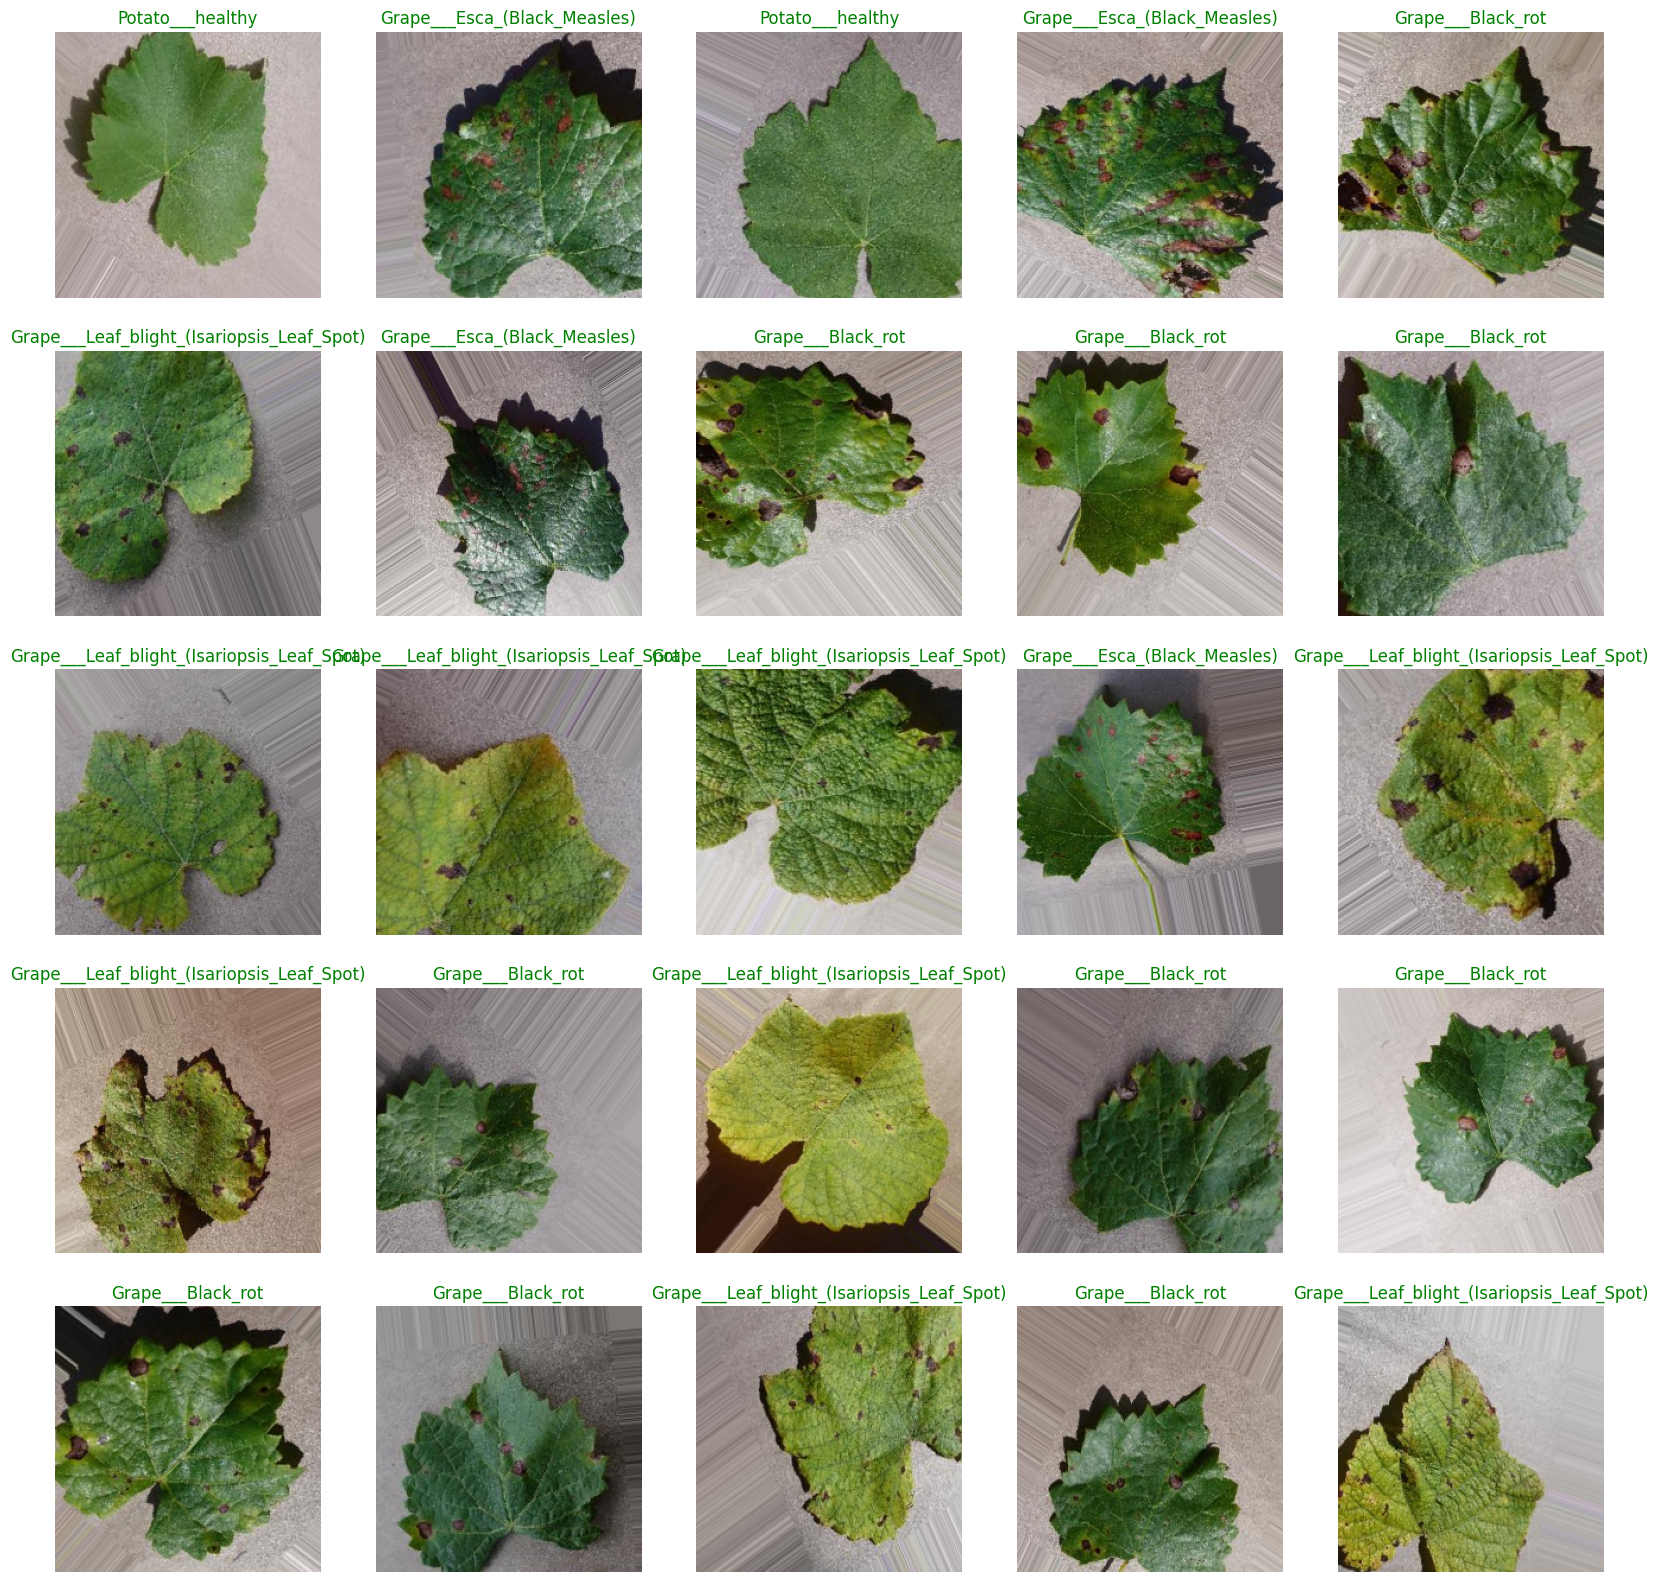

In [10]:
def show_images(image_gen):
    class_dict = image_gen.class_indices
    classes = list(class_dict.keys())
    
    images, labels = next(image_gen)
    
    plt.figure(figsize=(20, 20))
    
    num_images = min(len(labels), 25)
    
    for i in range(num_images):
        plt.subplot(5, 5, i + 1)
        
        image = images[i]
        
        plt.imshow(image)
        
        index = np.argmax(labels[i])
        class_name = classes[index]
        
        plt.title(class_name, color="green", fontsize=12)
        plt.axis('off')
    
    plt.show()

show_images(train_generator)

In [49]:

input_shape = (224, 224, 3)  
n_classes = len(train_generator.class_indices)

model = keras.Sequential([
    keras.layers.Conv2D(filters=64, kernel_size=(7, 7), strides=(3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPool2D(pool_size=(3, 3)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Conv2D(filters=256, kernel_size=(3, 3), activation='relu', padding='same'),
    keras.layers.MaxPool2D(pool_size=(2, 2)),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='relu'),
    keras.layers.Dense(512, activation='relu'),

    keras.layers.Dense(n_classes, activation='softmax')
])


model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.optimizers.Adam(),
    metrics=['accuracy']
)

model.summary()


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_40 (Conv2D)              │ (None, 73, 73, 64)     │         9,472 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_40 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_41 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_42 (MaxPooling2D) │ (None, 6, 6, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 6, 6, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_43 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_44 (Conv2D)              │ (None, 3, 3, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_44 (MaxPooling2D) │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_8 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 512)            │       131,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,512,452 (5.77 MB)

 Trainable params: 1,512,452 (5.77 MB)

 Non-trainable params: 0 (0.00 B)

In [50]:
# Fit the model
history = model.fit(
    train_generator,
    batch_size=32,
    validation_data=valid_generator,
    epochs=100
)

Epoch 1/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 36s 331ms/step - accuracy: 0.3207 - loss: 1.3332 - val_accuracy: 0.2998 - val_loss: 1.3429
Epoch 2/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 297ms/step - accuracy: 0.3591 - loss: 1.2938 - val_accuracy: 0.4300 - val_loss: 1.3229
Epoch 3/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 300ms/step - accuracy: 0.4229 - loss: 1.2144 - val_accuracy: 0.5307 - val_loss: 1.0342
Epoch 4/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 301ms/step - accuracy: 0.4511 - loss: 1.1906 - val_accuracy: 0.4447 - val_loss: 1.3987
Epoch 5/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 300ms/step - accuracy: 0.5575 - loss: 1.0026 - val_accuracy: 0.6192 - val_loss: 0.9543
Epoch 6/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 30s 310ms/step - accuracy: 0.5951 - loss: 0.9420 - val_accuracy: 0.6192 - val_loss: 0.8750
Epoch 7/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 302ms/step - accuracy: 0.6131 - loss: 0.8861 - val_accuracy: 0.5946 - val_loss: 0.9307
Epoch 8/100
89/89 ━━━━━━━━━━━━━━━━━━━━ 29s 303ms/step - accuracy: 0.5385 - loss: 1.0899 - 

In [51]:
scores = model.evaluate(test_generator)
scores

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9787 - loss: 0.0547


[0.037028633058071136, 0.9876847267150879]

26/26 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step


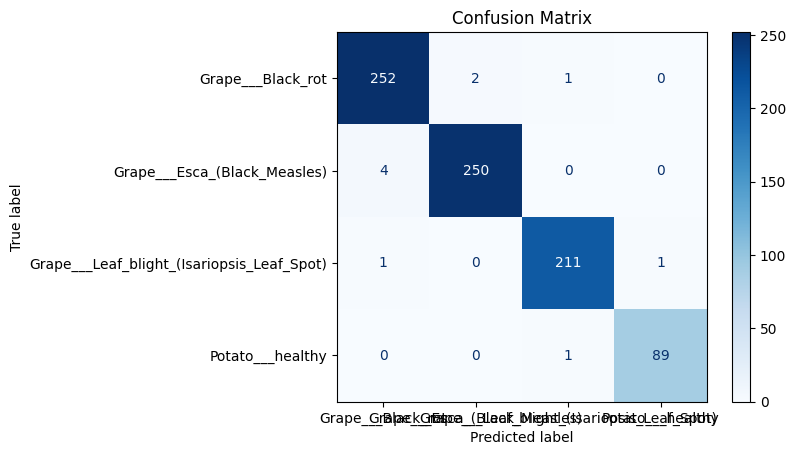

In [52]:
predictions = model.predict(test_generator)

predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

cm = confusion_matrix(true_classes, predicted_classes)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [53]:
test_generator.reset()
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step


In [54]:
from sklearn.metrics import classification_report 

class_labels = list(test_generator.class_indices.keys())
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

                                            precision    recall  f1-score   support

                         Grape___Black_rot       0.98      0.99      0.98       255
              Grape___Esca_(Black_Measles)       0.99      0.98      0.99       254
Grape___Leaf_blight_(Isariopsis_Leaf_Spot)       0.99      0.99      0.99       213
                          Potato___healthy       0.99      0.99      0.99        90

                                  accuracy                           0.99       812
                                 macro avg       0.99      0.99      0.99       812
                              weighted avg       0.99      0.99      0.99       812



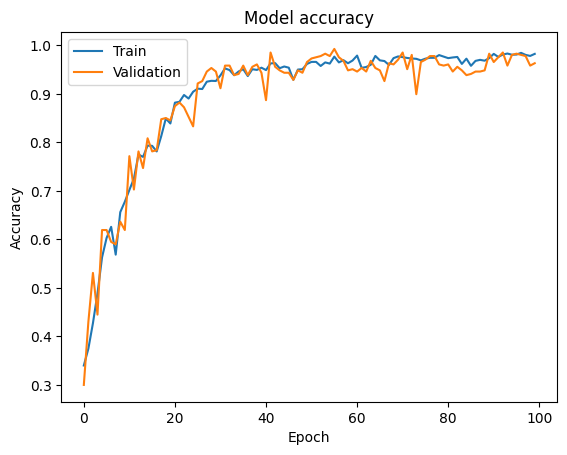

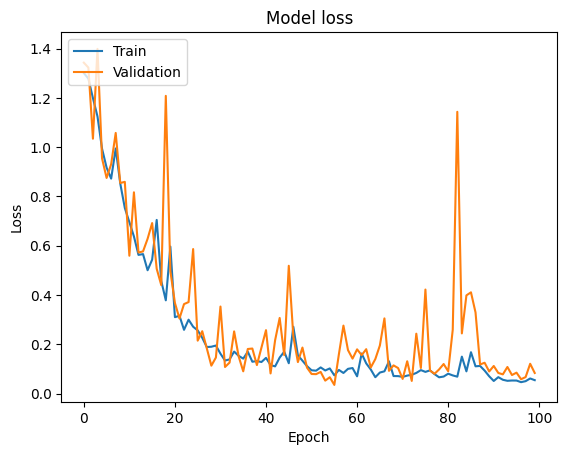

In [55]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [56]:
class_names = list(test_generator.class_indices.keys())

images_batch, labels_batch = next(test_generator)

first_image = images_batch[0]
first_label = np.argmax(labels_batch[0]) 

batch_prediction = model.predict(images_batch)
predicted_label_index = np.argmax(batch_prediction[0])

print("Actual label:", class_names[first_label])
print("Predicted label:", class_names[predicted_label_index])


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 469ms/step
Actual label: Grape___Black_rot
Predicted label: Grape___Black_rot


In [57]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

for images_batch, labels_batch in test_generator:
    for i in range(min(len(images_batch), 9)):
        predicted_class, confidence = predict(model, images_batch[i])
        actual_class = class_names[np.argmax(labels_batch[i])] 
        
        print(f"Actual: {actual_class}, Predicted: {predicted_class}, Confidence: {confidence}%")
        
    break  

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
Actual: Grape___Black_rot, Predicted: Grape___Black_rot, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Predicted: Grape___Leaf_blight_(Isariopsis_Leaf_Spot), Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: Grape___Black_rot, Predicted: Grape___Black_rot, Confidence: 97.73%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Actual: Potato___healthy, Predicted: Grape___Black_rot, Confidence: 99.59%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: Grape___Black_rot, Predicted: Grape___Black_rot, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: Grape___Black_rot, Predicted: Grape___Black_rot, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: Grape___Black_rot, Predicted: Grape___Black_rot, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Actual: Grape___Black_rot, Predicted: Grape___Black_rot, Confidence: 100.0%
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


In [58]:
model.save("Model_G_v2.h5")